In [2]:
import os
import cv2 
import time
import json
import numpy as np


from lightglue_utils import *
from preprocess_newdataset import *

import CSRansac

## Dataset 전처리

In [ ]:
origin_coordinates, float_origin_coordinates = get_origin_coordinates()
images = get_images()
lengths = get_lens()

## 에러 평가 코드(인접 프레임)

In [38]:
epochs = 1

for video_type in range(0, 5):
    # 각종 평가 수치들
    misannotate_errors = []
    pixel_errors = []
    failed_inliers = 0
    zero_inliers = 0
    inlier_rates = 0
    
    for epoch in range(epochs):
        len_videos = len(origin_coordinates[video_type]) # 동영상의 개수
        coord_list = [[] for _ in range(len_videos)]
        
        for video_index in range(len_videos):
            len_coord = len(origin_coordinates[video_type][video_index])
            len_images = len(images[video_type][video_index])
            
            # 이미지의 길이만큼
            _images = images[video_type][video_index]
            
            coord_list[video_index] = [[] for _ in range(len_images)]
            
            img0 = _images[0]
            
            for i in range(len_images):
                x = origin_coordinates[video_type][video_index][i][0]
                y = origin_coordinates[video_type][video_index][i][1]
                
                if i != len_images - 1:
                    img1 = _images[i + 1]
                    
                    # LightGlue
                    results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
                    target_keypoint = results_lightglue["points0"].cpu().numpy()
                    frame_keypoint = results_lightglue["points1"].cpu().numpy()
                    if len(target_keypoint) < 6:
                        failed_inliers += 1
                        continue

                    homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                    if mask <= 0.3:
                        if mask == 0:
                            zero_inliers += 1
                        failed_inliers += 1
                    
                    inlier_rates += mask
                    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

                    coord_list[video_index][i].append(projected_pts)
                    
                    img0 = img1
                    
                    
        #에러 측정            
        # disappear_error = 0
        misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinates[video_type], len_coord)
                
        #print("disappear_error:", disappear_error)
        misannotate_errors.append(misannotate_error)
        pixel_errors.append(pixel_error)
        
    
    
    error1 = sum(misannotate_errors) / len(misannotate_errors)
    error2 = sum(pixel_errors) / len(pixel_errors)
    error3 = inlier_rates / (len(lengths[video_type]) * epochs)

    print("failed_inliers:", failed_inliers)
    print("zero_inliers:", zero_inliers)
    print("misannotate_error:", error1)
    print("pixel_error:", error2)
    print("inlier_rate:", error3)
    print()

(262.99615537328606, 186.28899835987974)


AttributeError: 'tuple' object has no attribute 'type'

In [16]:
#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
epochs = 2

for index in range(0, 5):
    # 각종 평가 수치들
    misannotate_errors = []
    pixel_errors = []
    failed_inliers = 0
    zero_inliers = 0
    inlier_rates = 0
    
    len_coord = len(origin_coordinates[index])
    coord_list = [[] for _i in range(len(origin_coordinates[index]))]
    
    # 10번 반복하여 측정한 에러를 구함
    for k in range(epochs):
        # 좌표의 개수(동영상의 개수)만큼 반복
        for i in range(len_coord):
            _images = images[index][i]
            _len_images = len(_images)
            
            x = origin_coordinates[index][i][0]
            y = origin_coordinates[index][i][1]
            
            # 두 번째 차원의 리스트 초기화
            coord_list[i] = [[] for _ in range(_len_images)]

            img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
            
            for j in range(_len_images):
                if j != _len_images - 1:
                    img1 = _images[j+1]

                    # LightGlue
                    results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
                    target_keypoint = results_lightglue["points0"].cpu().numpy()
                    frame_keypoint = results_lightglue["points1"].cpu().numpy()
                    if len(target_keypoint) < 6:
                        failed_inliers += 1
                        continue

                    homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                    if mask <= 0.3:
                        if mask == 0:
                            zero_inliers += 1
                        failed_inliers += 1
                    
                    inlier_rates += mask
                    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

                    coord_list[i][j].append(projected_pts)
                    
                    img0 = img1
                    x = projected_pts[0]
                    y = projected_pts[1]
                    
        #에러 측정            
        # disappear_error = 0
        misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinates[index], len_coord)
                
        #print("disappear_error:", disappear_error)
        misannotate_errors.append(misannotate_error)
        pixel_errors.append(pixel_error)
        
    
    
    error1 = sum(misannotate_errors) / len(misannotate_errors)
    error2 = sum(pixel_errors) / len(pixel_errors)
    error3 = inlier_rates / (len(lengths[index]) * epochs)

    print("failed_inliers:", failed_inliers)
    print("zero_inliers:", zero_inliers)
    print("misannotate_error:", error1)
    print("pixel_error:", error2)
    print("inlier_rate:", error3)
    print()

failed_inliers: 22178
zero_inliers: 0
misannotate_error: 0.5
pixel_error: 0.0961069490830834
inlier_rate: 0.8316822044444913

failed_inliers: 32372
zero_inliers: 0
misannotate_error: 0.4
pixel_error: 0.10667310724099914
inlier_rate: 0.6831353971849062

failed_inliers: 20529
zero_inliers: 0
misannotate_error: 0.1
pixel_error: 0.08448434681565134
inlier_rate: 0.8357186765942877

failed_inliers: 85901
zero_inliers: 0
misannotate_error: 3.9
pixel_error: 0.14904979391949064
inlier_rate: 0.7363167489959468

failed_inliers: 85145
zero_inliers: 0
misannotate_error: 8.0
pixel_error: 0.21190722618754756
inlier_rate: 0.738144709490343



## 저널용 비디오 생성

In [15]:
# import os

target_images = []
target_image_dir = "jernal_targer_image"

videos = []
videos_dir = "jernal_videos"

for image in os.listdir(target_image_dir):
    target_images.append(os.path.join(target_image_dir, image))
    
for video in os.listdir(videos_dir):
    video_path = os.path.join(videos_dir, video)
    video = []
    for frame in os.listdir(video_path):
        video.append(os.path.join(video_path, frame))
        
    videos.append(video)


print(target_images)
print(videos)

['jernal_targer_image\\WheelAndTireAssemblyRemoval_00007_01.png', 'jernal_targer_image\\WheelAndTireAssemblyRemoval_00007_02.png', 'jernal_targer_image\\WheelAndTireAssemblyRemoval_00007_03.png', 'jernal_targer_image\\WheelAndTireAssemblyRemoval_00007_04.png', 'jernal_targer_image\\WheelAndTireAssemblyRemoval_00007_05.png']
[['jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0000.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0001.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0002.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0003.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0004.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0005.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0006.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0007.jpg', 'jernal_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0008.jpg', 'jernal_videos\\WheelAndTireAssem

In [16]:
coordinates = [[0.5000092, 0.5369453], [0.5000096, 0.5369451000000001], [0.4271423, 0.4999952], [0.4205159, 0.5372209], [0.4270934, 0.5285428]]

In [37]:
# Lightglue
for i in range (3, 5):    
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('annotated_lightglue_' + str(i) + '.mp4', fourcc, 30, (640, 480))
    
    x, y = coordinates[i]
    x = x * 1280
    y = y * 960
    
    img0 = target_images[i]
    
    # 각 프레임 처리
    for frame in range(len(videos[i])):
        _frame = cv2.imread(videos[i][frame])
        img1 = videos[i][frame]
        
        
        # LightGlue
        results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
        target_keypoint = results_lightglue["points0"].cpu().numpy()
        frame_keypoint = results_lightglue["points1"].cpu().numpy()

        homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
        
        x, y = CSRansac.perspective_transform(np.array([x, y]), homography)

        cv2.circle(_frame, (int(x), int(y)), 15, (0, 0, 255), -1)
        cv2.circle(_frame, (int(x), int(y)), 3, (0, 0, 0), -1)
        #cv2.imshow('frame', _frame)
        
        img0 = img1
        
        out.write(_frame)
        
        # key = cv2.waitKey(5)
        # if key == 27:
        #     break
        
    out.release()
    # cap.release()

cv2.destroyAllWindows()


## 졸업용 속도 측정 + inlier rate 그래프 그리기

In [5]:
video_images = [[] for _ in range(5)]

index = 0

for video in os.listdir('grad_videos'):
    image_path = os.path.join('grad_videos', video)
    video_image = []
    
    for images in os.listdir(image_path):
        image = os.path.join(image_path, images)
        video_image.append(image)
        
    video_images[index].append(video_image)
    
    index += 1

In [6]:
video_coords = []

for coord in os.listdir('grad_coord'):
    coord_path = os.path.join('grad_coord', coord)
    coord_list = []
    
    with open (coord_path, 'r') as f:
        file = json.load(f)
        coord = file["annotationList"]
        coord = coord[1:-1]
        coord_list.append(coord)
            
    video_coords.append(coord_list)
    
print(len(video_coords))

5


In [7]:
lightglue_inliers = []

In [8]:
print((video_images[0]))

[['grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0000.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0001.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0002.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0003.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0004.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0005.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0006.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0007.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0008.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0009.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0010.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0011.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0012.jpg', 'grad_videos\\WheelAndTireAssemblyRemoval_00007_01\\frame_0013.jpg', 'grad_videos\\WheelAndTireAssemb

In [10]:
# Lightglue
for index in range(5):
    video_coord = video_coords[index][0]
    video_image = video_images[index][0]
    # fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    # out = cv2.VideoWriter('annotated_lightglue_' + str(i) + '.mp4', fourcc, 30, (640, 480))
    
    coord = video_coord[0]
    x = coord[0] * 640
    y = coord[1] * 480
    
    frame_count = 0
    total_time = 0
    
    img0 = video_image[0]
    
    lightglue_inlier = []
    
    start_time = time.time()
    # 각 프레임 처리
    for frame in range(len(video_image)):
        # _frame = cv2.imread(videos[i][frame])
        img1 = video_image[frame]
        if frame == 0:
            continue
        
        # LightGlue
        results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
        target_keypoint = results_lightglue["points0"].cpu().numpy()
        frame_keypoint = results_lightglue["points1"].cpu().numpy()

        homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
        projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
        #cv2.imshow('frame', _frame)
        
        img0 = img1
        
        lightglue_inlier.append(mask)
        
        # key = cv2.waitKey(5)
        # if key == 27:
        #     break
        
        frame_count += 1
        
    end_time = time.time()
    
    total_time += end_time - start_time   
    average_time = frame_count / total_time
    print("FPS : ", average_time)
    
    lightglue_inliers.append(lightglue_inlier)
        

FPS :  10.630905314478982
FPS :  11.139875326113692
FPS :  11.034000790059078
FPS :  11.03349075618541
FPS :  10.940371759274575


## 그래프 그리기

In [6]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# inlier rates 가져오기
LightGlue_inliers = None
SuperGlue_inliers = None

with open('LightGlue_inliers.json', 'r') as f:
    LightGlue_inliers = json.load(f)
    
with open('SuperGlue_inliers.json', 'r') as f:
    SuperGlue_inliers = json.load(f)

In [7]:
for i in range(5):
    for j in range(len(LightGlue_inliers[i])):
        if LightGlue_inliers[i][j] < 0.3 and j > 0:
            LightGlue_inliers[i][j] = LightGlue_inliers[i][j-1]
            
for i in range(5):
    for j in range(len(SuperGlue_inliers[i])):
        if SuperGlue_inliers[i][j] < 0.3 and j > 0:
            SuperGlue_inliers[i][j] = SuperGlue_inliers[i][j-1]
            

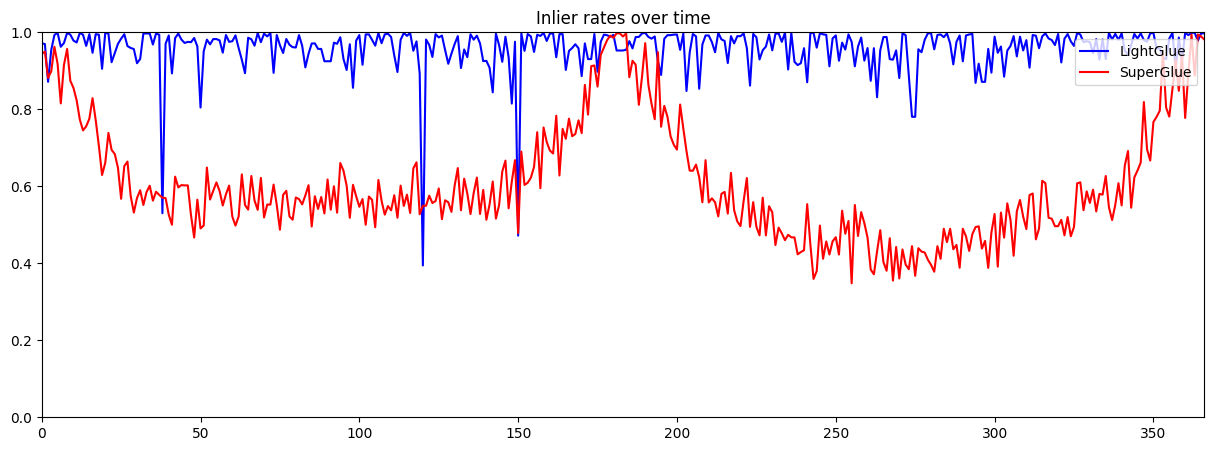

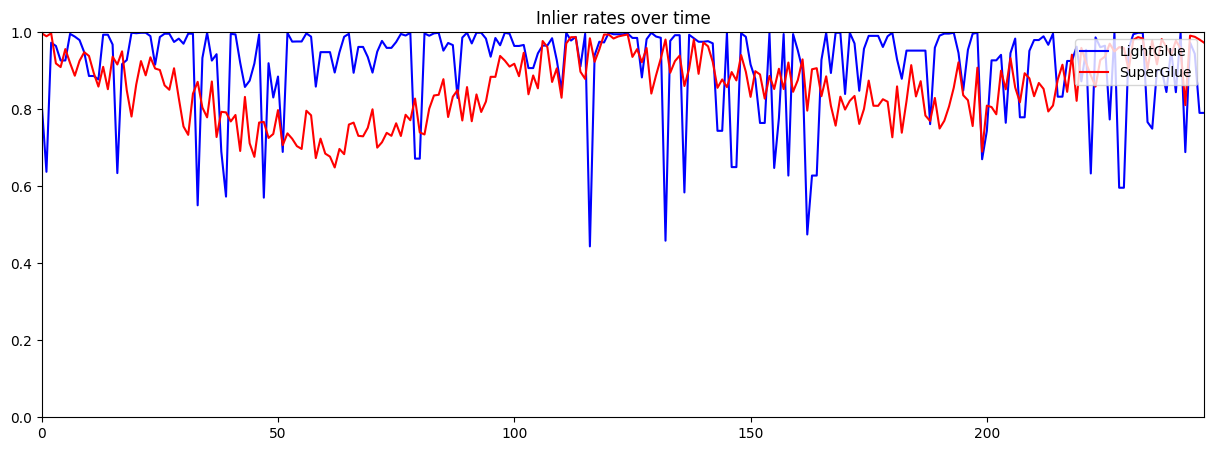

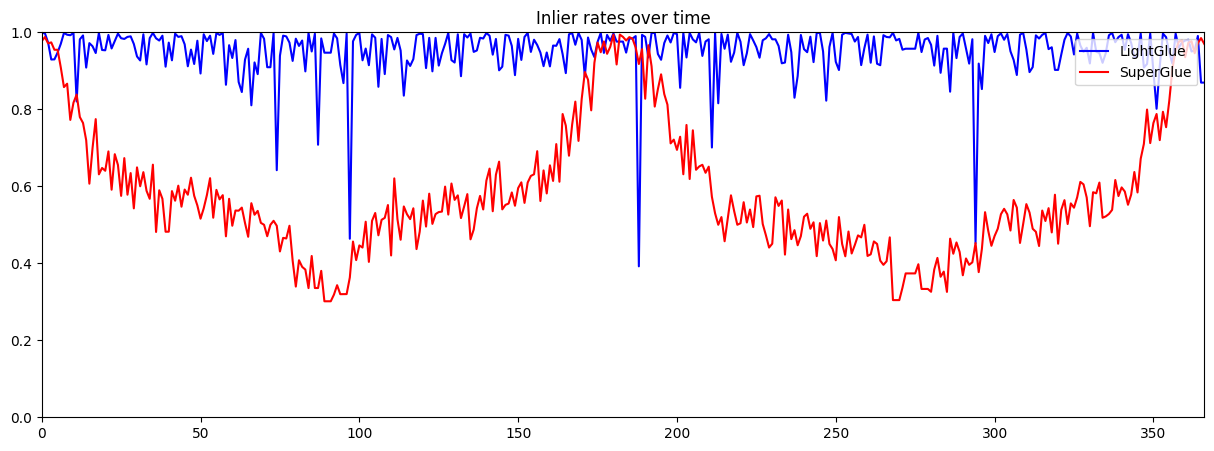

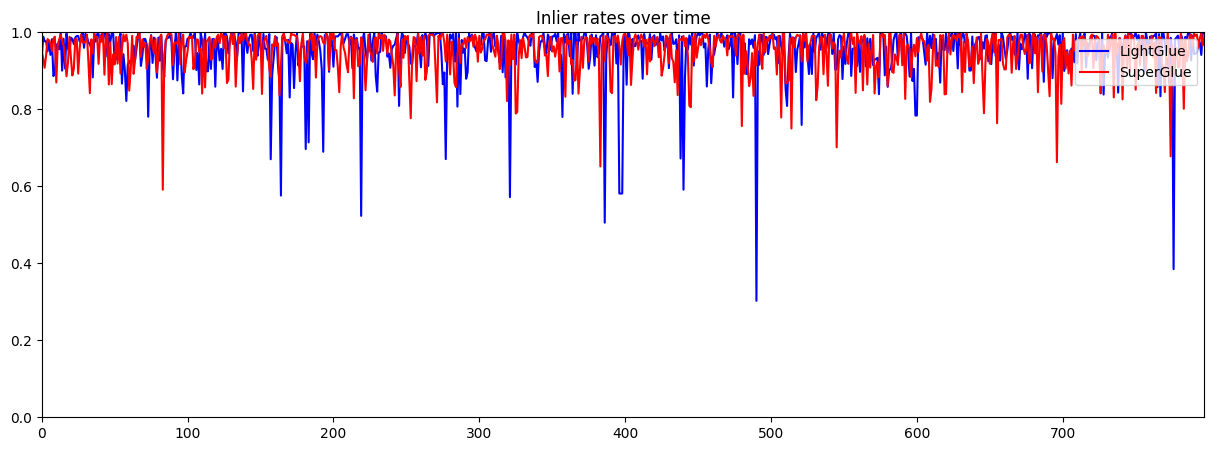

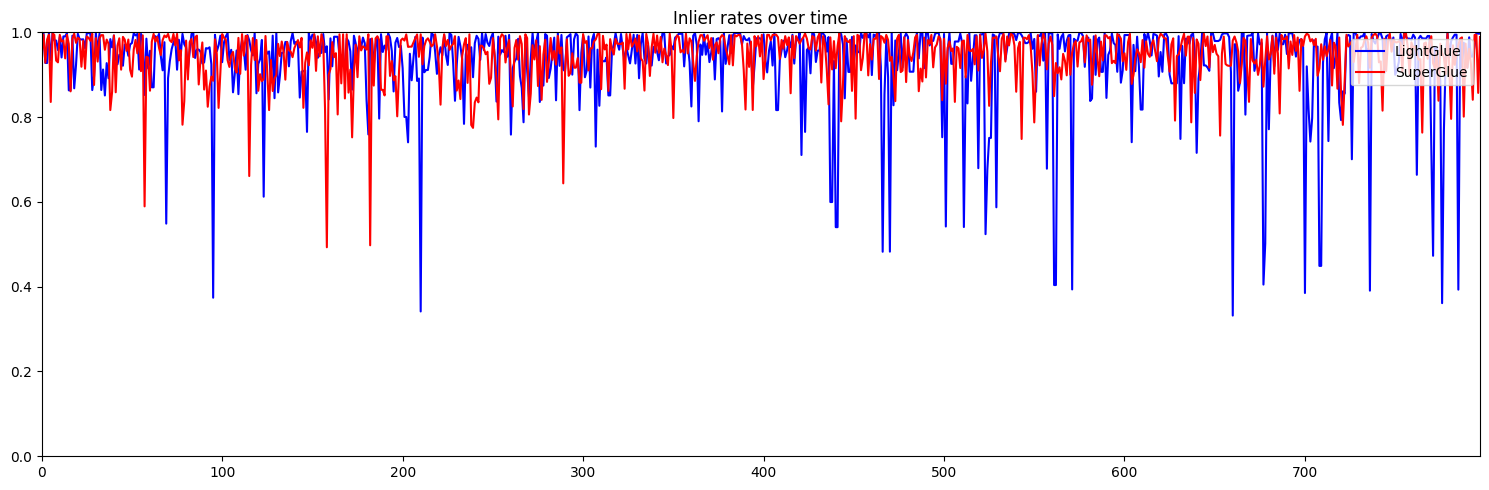

In [8]:
# 각 데이터를 별도의 서브플롯에 그리기
for i in range(5):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    
    axes.plot(LightGlue_inliers[i], color='blue', label='LightGlue')   # 빨간색 그래프
    axes.plot(SuperGlue_inliers[i], color='red', label='SuperGlue')  # 파란색 그래프
    axes.set_title(f'Inlier rates over time')                     # 그래프 제목 설정
    axes.set_ylim(0, 1)                                # y축 범위 설정
    axes.set_xlim(0, len(LightGlue_inliers[i]) - 1)                # x축 범위 설정
    axes.legend(loc='upper right')                     # 범례 위치 설정

plt.tight_layout()                                        # 레이아웃 조정
plt.show()    

In [19]:
sum(SuperGlue_inliers[3]) / 799


0.9387944695333795